In [1]:
from PIL import Image, ImageDraw, ImageFont
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
%matplotlib inline

First, in order to visualise the dataset, we need a font that can display the full range of Japanese characters. We're using Noto Sans, an open source font by Google which can display very almost all the characters used within this competition.

In [2]:
fontsize = 50

# From https://www.google.com/get/noto/
the_file = './NotoSansCJKjp-Regular.otf'
if not os.path.isfile(the_file):
    !wget -q --show-progress https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
    !unzip -p NotoSansCJKjp-hinted.zip NotoSansCJKjp-Regular.otf > NotoSansCJKjp-Regular.otf
    !rm NotoSansCJKjp-hinted.zip

font = ImageFont.truetype(the_file, fontsize, encoding='utf-8')

### Visualising the training data

You'll notice that some of the characters "off to the side" of columns in the text aren't annotated in the training set. These characters are annotations and not part of the main text of the books, so they shouldn't be transcribed by your model.

In [3]:
train_df = pd.read_csv('../input/train.csv')
pred_df = pd.read_csv('../cache/train_true_result.csv')
unicode_map = {codepoint: char for codepoint, char in pd.read_csv('../input/unicode_translation.csv').values}

In [4]:
# This function takes in a filename of an image, and the labels in the string format given in train.csv,
# and returns an image containing the bounding boxes and characters annotated
def visualize_training_data(image_fn, labels):
    # Convert annotation string to array
    labels = np.array(labels.split(' ')).reshape(-1, 5)
    
    # Read image
    imsource = Image.open(image_fn).convert('RGBA')
    bbox_canvas = Image.new('RGBA', imsource.size)
    char_canvas = Image.new('RGBA', imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas) # Separate canvases for boxes and chars so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)

    for codepoint, x, y, w, h in labels:
        x, y, w, h = int(x), int(y), int(w), int(h)
        char = unicode_map[codepoint] # Convert codepoint to actual unicode character

        # Draw bounding box around character, and unicode character next to it
        bbox_draw.rectangle((x, y, x+w, y+h), fill=(255, 255, 255, 0), outline=(255, 0, 0, 255))
        char_draw.text((x + w + fontsize/4, y + h/2 - fontsize), char, fill=(0, 0, 255, 255), font=font)

    imsource = Image.alpha_composite(Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert("RGB") # Remove alpha for saving in jpg format.
    return np.asarray(imsource)

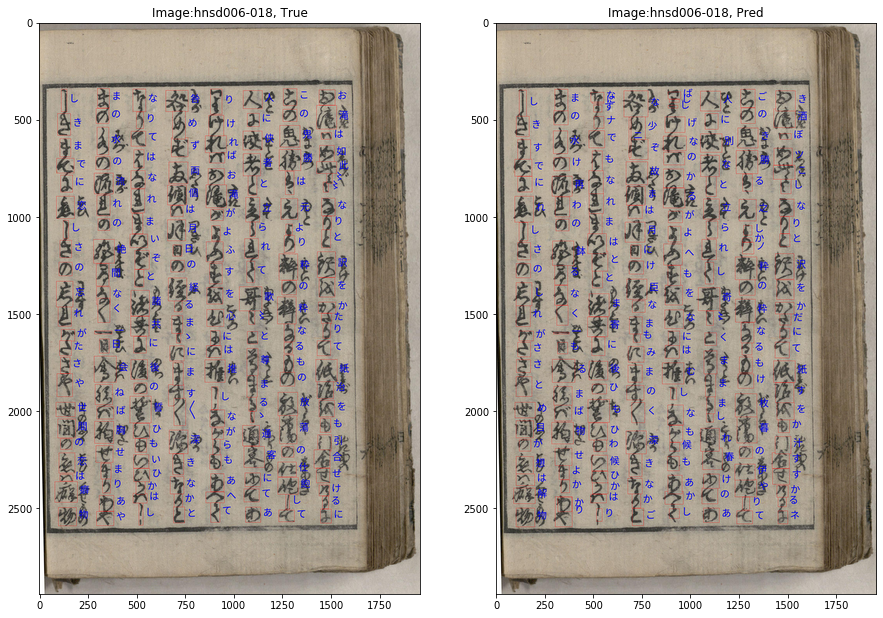

In [5]:
random_idx = np.random.randint(len(train_df))

img, labels = train_df.values[random_idx]
viz1 = visualize_training_data('../input/train_images/{}.jpg'.format(img), labels)

img, labels = pred_df.values[random_idx]
viz2 = visualize_training_data('../input/train_images/{}.jpg'.format(img), labels)

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title("Image:{}, True".format(img))
plt.imshow(viz1, interpolation='lanczos')

plt.subplot(122)
plt.title("Image:{}, Pred".format(img))
plt.imshow(viz2, interpolation='lanczos')

plt.show()

### Visualising predictions

For the test set, you're only required to predict a single point within each bounding box instead of the entire bounding box (ideally, the centre of the bounding box). It may also be useful to visualise the box centres on the image:

In [8]:
# This function takes in a filename of an image, and the labels in the string format given in a submission csv, and returns an image with the characters and predictions annotated.
def visualize_predictions(image_fn, labels):
    # Convert annotation string to array
    labels = np.array(labels.split(' ')).reshape(-1, 3)
    
    # Read image
    imsource = Image.open(image_fn).convert('RGBA')
    bbox_canvas = Image.new('RGBA', imsource.size)
    char_canvas = Image.new('RGBA', imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas) # Separate canvases for boxes and chars so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)

    for codepoint, x, y in labels:
        x, y = int(x), int(y)
        char = unicode_map[codepoint] # Convert codepoint to actual unicode character

        # Draw bounding box around character, and unicode character next to it
        bbox_draw.rectangle((x-10, y-10, x+10, y+10), fill=(255, 0, 0, 255))
        char_draw.text((x+25, y-fontsize*(3/4)), char, fill=(255, 0, 0, 255), font=font)

    imsource = Image.alpha_composite(Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert("RGB") # Remove alpha for saving in jpg format.
    return np.asarray(imsource)

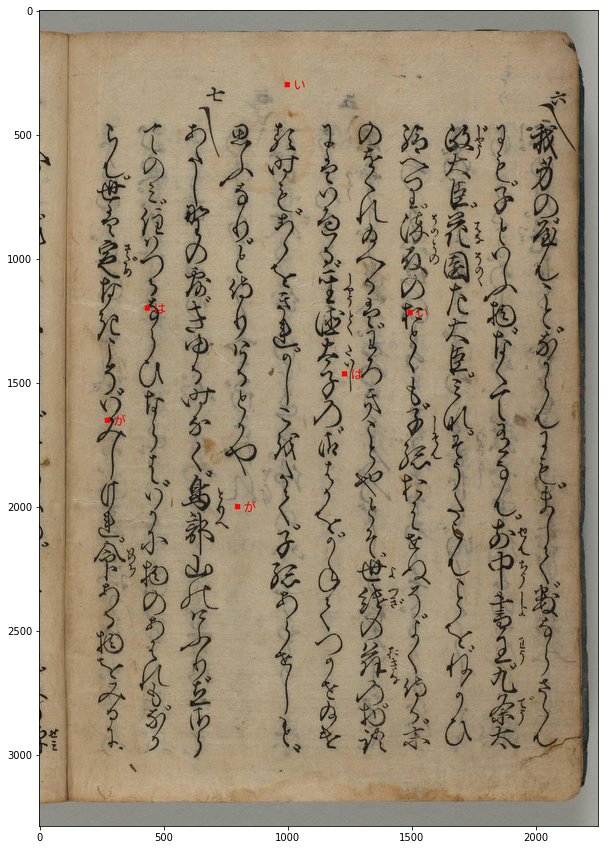

In [9]:
image_fn = './data/test_images/test_030d9355.jpg'
pred_string = 'U+306F 1231 1465 U+304C 275 1652 U+3044 1495 1218 U+306F 436 1200 U+304C 800 2000 U+3044 1000 300' # Prediction string in submission file format
viz = visualize_predictions(image_fn, pred_string)

plt.figure(figsize=(15, 15))
plt.imshow(viz, interpolation='lanczos')